## GoogLeNet (2014) - Inception Network


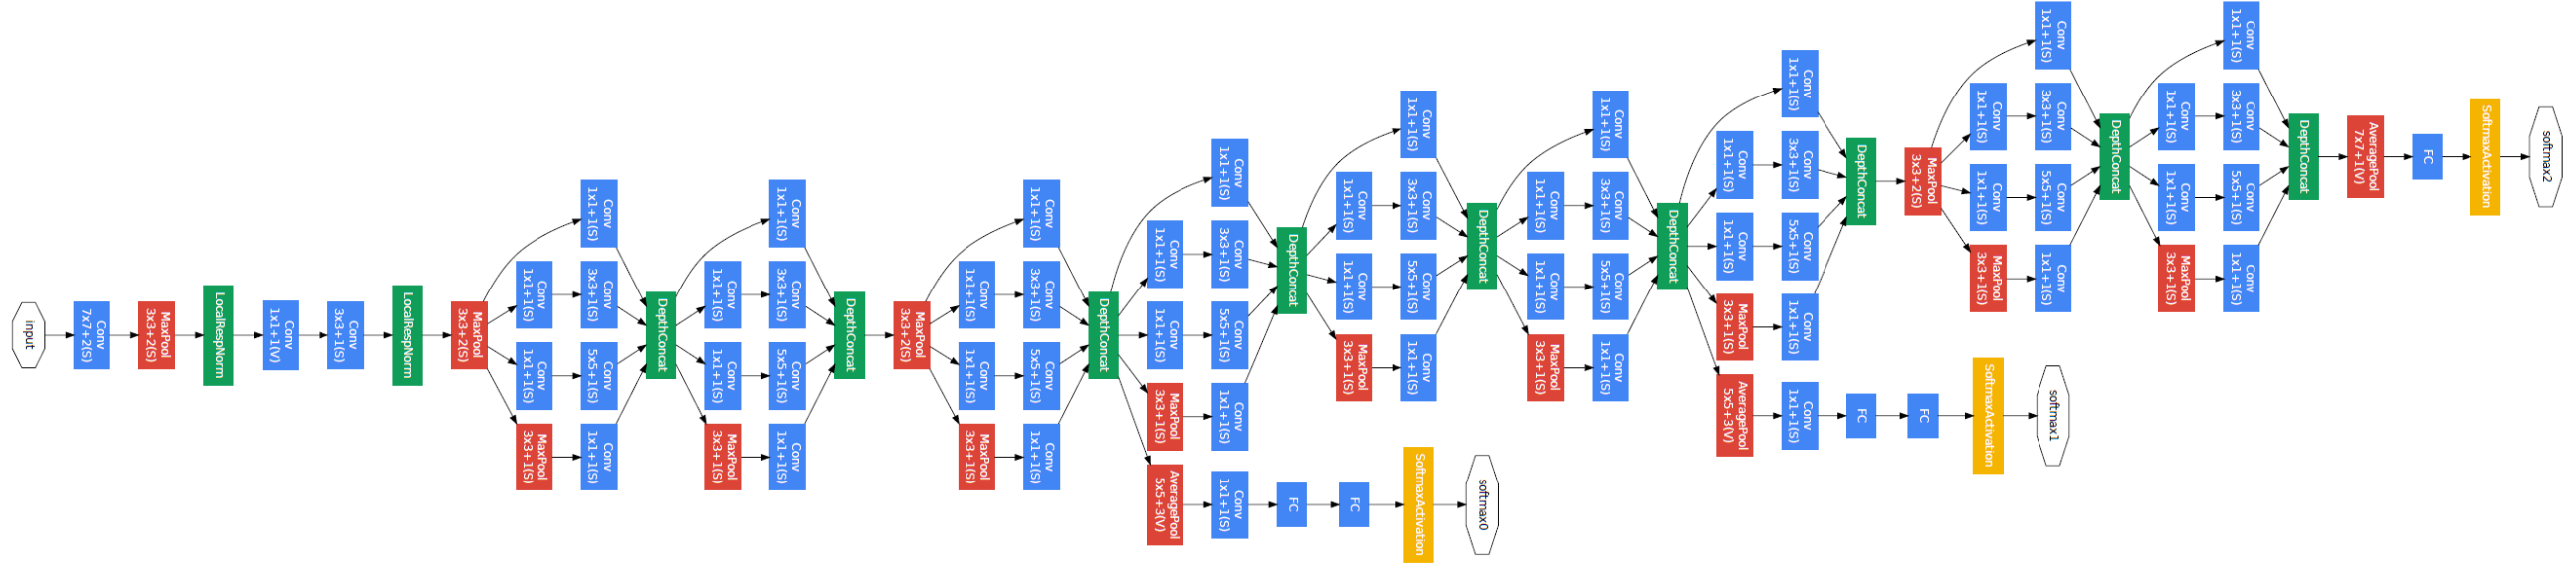






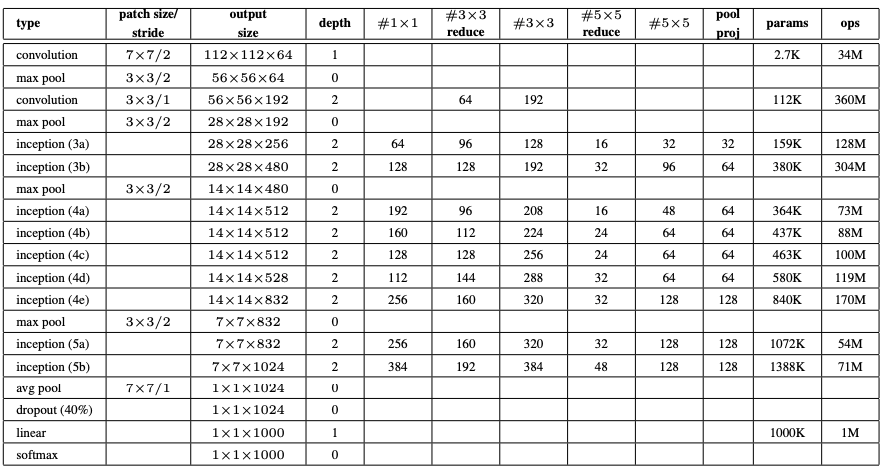





inception module: used to solve the problem of overfitting

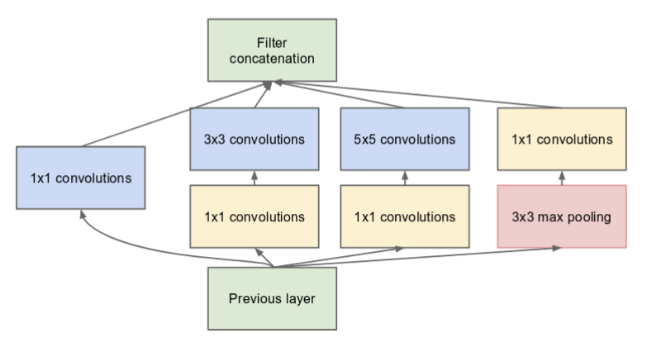

1*1 convolution used to reduce the dimenssions of neural network and perform faster computations, decrease the number of parameters (weights and biases) of the architecture. By reducing the parameters we also increase the depth of the architecture.




The architecture also contains two auxiliary classifier layer connected to the output of Inception (4a) and Inception (4d) layers. The architectural details of auxiliary classifiers as follows:
- An average pooling layer of filter size 5×5 and stride 3.
- A 1×1 convolution with 128 filters for dimension reduction and ReLU activation.
- A fully connected layer with 1025 outputs and ReLU activation
- Dropout Regularization with dropout ratio = 0.7
- A softmax classifier with 1000 classes output similar to the main softmax classifier.

## Libraries

In [ ]:
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import transforms

!pip install kaggle


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d akash2sharma/tiny-imagenet

 98% 465M/474M [00:03<00:00, 164MB/s]
100% 474M/474M [00:03<00:00, 156MB/s]


In [ ]:
!unzip tiny-imagenet.zip

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/content/tiny-imagenet-200/train", transform= transform)

In [ ]:
train_dataset, valid_dataset, test_dataset= torch.utils.data.random_split(dataset, [80000, 10000, 10000])

batch_size= 64

train_loader= torch.utils.data.DataLoader(train_dataset, batch_size, shuffle= True)
valid_loader= torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle= False)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size, shuffle= False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


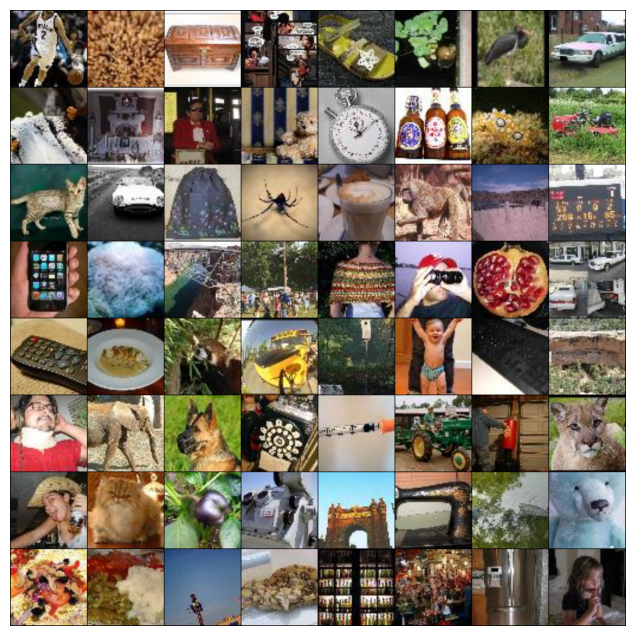

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## GoogleNet Class

In [ ]:
class convblock(nn.Module):
  def __init__(self, input_ch, out_ch, kernel_size, **kwargs):
    super(convblock, self).__init__()

    self.conv = nn.Conv2d(input_ch, out_ch, kernel_size= kernel_size, **kwargs)
    self.batchnormalize = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.batchnormalize(out)
    out = self.relu(out)

    return out

In [ ]:
class inceptionblock(nn.Module):
  def __init__(self, input_ch, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
    super(inceptionblock, self).__init__()

    self.conv_1x1 = convblock(input_ch, num_1x1, kernel_size=1)

    self.conv_3x3_red = nn.Conv2d(input_ch, num_3x3_red, kernel_size=1)
    self.conv_3x3 = nn.Conv2d(num_3x3_red, num_3x3, kernel_size=3, padding= 1)

    self.conv_5x5_red = nn.Conv2d(input_ch, num_5x5_red, kernel_size=1)
    self.conv_5x5 = nn.Conv2d(num_5x5_red, num_5x5, kernel_size=5, padding= 2)

    self.pool = nn.MaxPool2d(kernel_size= 3, stride= 1, padding= 1)
    self.pool_proj= convblock(input_ch, num_pool_proj, kernel_size=1)

  def forward(self, x):
    x1= self.conv_1x1(x)

    x2= self.conv_3x3_red(x)
    x2= self.conv_3x3(x2)

    x3= self.conv_5x5_red(x)
    x3= self.conv_5x5(x3)

    x4= self.pool(x)
    x4= self.pool_proj(x4)

    out= torch.cat([x1, x2, x3, x4], 1)

    return out

In [ ]:
class auxiliary(nn.Module):
  def __init__(self, in_ch, num_classes):
    super(auxiliary, self).__init__()

    self.avgpool= nn.AvgPool2d(kernel_size= 5, stride= 3)

    self.conv_1x1= convblock(in_ch, 128, kernel_size= 1)

    self.linear= nn.Linear(2048, 1024)

    self.relu= nn.ReLU()

    self.dropout= nn.Dropout(0.7)

    self.linear= nn.Linear(1024, num_classes)

  def forward(self, x):
    out = self.avgpool(x)
    out= self.conv_1x1(out)
    out = out.reshape(out.shape[0], -1)
    out= self.linear(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.linear(out)

    return out

In [ ]:
class GoogleNet(nn.Module):
  def __init__(self, use_auxiliary=True, num_classes= 1000):
    super(GoogleNet, self).__init__()

    self.conv1= convblock(3, 64, kernel_size= 7, stride= 2, padding= 3)
    self.conv2= convblock(64, 192, kernel_size= 7, stride= 1, padding= 1)

    self.maxpool= nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1)

    self.avgpool= nn.AvgPool2d(kernel_size= 7, stride= 1)

    self.dropout= nn.Dropout(0.4)

    self.linear = nn.Linear(1024, num_classes)

    self.use_auxiliary= use_auxiliary
    if self.use_auxiliary == True:
      self.auxiliary_4a= auxiliary(512, 1000)
      self.auxiliary_4d= auxiliary(528, 1000)

    self.inception_3a= inceptionblock(192, 64, 96, 128, 16, 32, 32)
    self.inception_3b= inceptionblock(256, 128, 128, 192, 32, 96, 64)

    self.inception_4a= inceptionblock(480, 192, 96, 208, 16, 48, 64)
    self.inception_4b= inceptionblock(512, 160, 112, 224, 24, 64, 64)
    self.inception_4c= inceptionblock(512, 128, 128, 256, 24, 64, 64)
    self.inception_4d= inceptionblock(512, 112, 144, 288, 32, 64, 64)
    self.inception_4e= inceptionblock(528, 256, 160, 320, 32, 128, 128)

    self.inception_5a= inceptionblock(832, 256, 160, 320, 32, 128, 128)
    self.inception_5b= inceptionblock(832, 384, 192, 384, 48, 128, 128)

  def forward(self, x):
    y = None
    z= None

    out = self.conv1(x)
    out = self.maxpool(out)

    out = self.conv2(out)
    out = self.maxpool(out)

    out = self.inception_3a(out)
    out = self.inception_3b(out)

    out = self.maxpool(out)

    out = self.inception_4a(out)
    if self.use_auxiliary:
      y = out

    out = self.inception_4b(out)
    out = self.inception_4c(out)
    out = self.inception_4d(out)
    if self.use_auxiliary:
      z = out

    out = self.inception_4e(out)

    out = self.maxpool(out)

    out = self.inception_5a(out)
    out = self.inception_5b(out)

    out = self.avgpool(out)

    out = out.reshape(out.shape[0], -1)

    out = self.dropout(out)

    out = self.linear(out)

    return y, z, out

## HyperParameters

In [ ]:
model = GoogleNet(use_auxiliary=True).to(device)

batch_size= 64
num_epochs= 10
learning_rate= 0.0001
total_step= len(train_loader)

cost= nn.CrossEntropyLoss()

optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
# total parameters

pytorch_total_params = sum(p.numel() for p in model.parameters())

# only trainable parameters

pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"all_parameters: {pytorch_total_params}, trainable_parameters_only: {pytorch_total_params_trainable}")

all_parameters: 9675144, trainable_parameters_only: 9675144


## Train

In [ ]:
for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image= image.to(device)
    label= label.to(device)

    _, _, pred= model(image)
    loss = cost(pred, label)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  with torch.no_grad():
    total= 0
    correct= 0

    for image, label in valid_loader:
      image= image.to(device)
      label= label.to(device)

      _, _, pred= model(image)

      _, prediction= torch.max(pred.data, 1)

      total += label.size(0)
      correct += (prediction == label).sum().item()

      del image, label, pred

    print('Accuracy of the network on the {} validation images: {} %'.format(10000, 100 * correct / total))

Epoch [1/10], Step [1250/1250], Loss: 4.0345
Accuracy of the network on the 10000 validation images: 15.32 %
Epoch [2/10], Step [1250/1250], Loss: 3.4211
Accuracy of the network on the 10000 validation images: 22.79 %
Epoch [3/10], Step [1250/1250], Loss: 3.0797
Accuracy of the network on the 10000 validation images: 27.43 %
Epoch [4/10], Step [1250/1250], Loss: 2.8071
Accuracy of the network on the 10000 validation images: 31.41 %
Epoch [5/10], Step [1250/1250], Loss: 2.5254
Accuracy of the network on the 10000 validation images: 33.52 %
Epoch [6/10], Step [1250/1250], Loss: 2.6579
Accuracy of the network on the 10000 validation images: 35.99 %
Epoch [7/10], Step [1250/1250], Loss: 2.4437
Accuracy of the network on the 10000 validation images: 37.31 %
Epoch [8/10], Step [1250/1250], Loss: 1.9469
Accuracy of the network on the 10000 validation images: 38.7 %
Epoch [9/10], Step [1250/1250], Loss: 2.1021
Accuracy of the network on the 10000 validation images: 39.4 %
Epoch [10/10], Step [

## Another way for training:

In [ ]:
# import time
# import copy

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):

#     since = time.time()
#     val_acc_history = []
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         for phase in ['train', 'val']: # Each epoch has a training and validation phase
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]: # Iterate over data

#                 inputs = inputs.to(device)

#                 labels = labels.to(device)

#                 optimizer.zero_grad() # Zero the parameter gradients

#                 with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train

#                     if phase == 'train': # Backward + optimize only if in training phase
#                         if use_auxiliary:
#                             aux1, aux2, outputs = model(inputs)
#                             loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
#                         else:
#                             _, _, outputs= model(inputs)
#                             loss = criterion(outputs, labels)

#                         _, preds = torch.max(outputs, 1)
#                         loss.backward()
#                         optimizer.step()

#                     if phase == 'val':
#                         _, _, outputs= model(inputs)
#                         loss = criterion(outputs, labels)
#                         _, preds = torch.max(outputs, 1)

#                 # Statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)

#             if phase == 'val': # Adjust learning rate based on val loss
#                 lr_scheduler.step(epoch_loss)

#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [ ]:
# model, _ = train_model(model, {"train": train_loader, "val": valid_loader}, cost, optimizer, num_epochs)

## Test

In [ ]:
  with torch.no_grad():
    total= 0
    correct= 0

    for image, label in test_loader:
      image= image.to(device)
      label= label.to(device)

      _, _, pred= model(image)

      _, prediction= torch.max(pred.data, 1)

      total += label.size(0)
      correct += (prediction == label).sum().item()

      del image, label, pred

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the 10000 test images: 40.18 %
